# Almond Dataset (MVP, 1차 학습)

## Kaggle에서 Almond 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahyeks/almond-varieties")

print("Path to dataset files:", path)

100%|██████████| 96.5M/96.5M [00:01<00:00, 99.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mahyeks/almond-varieties/versions/1


## 데이터셋에서 세부 클래스 확인

In [ ]:
import os
os.listdir(path + '/dataset')

['AK', 'SIRA', 'NURLU', 'KAPADOKYA']

## 필요한 라이브러리 설치

In [ ]:
!pip install split-folders
!pip install tensorflow
!pip install keras

## 필요한 라이브러리 임포트

In [ ]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders

## 학습, 검증, 테스트 데이터로 나누기 (70%, 15%, 15%)

In [ ]:
splitfolders.ratio(path + '/dataset', output=path + '/output_dataset', seed=2025, ratio=(0.7, 0.15, 0.15))

Copying files: 1556 files [00:00, 5334.16 files/s]


In [ ]:
os.listdir(path + '/output_dataset')

['test', 'train', 'val']

In [ ]:
train_dir = path + '/output_dataset/train'
val_dir = path + '/output_dataset/val'
test_dir = path + '/output_dataset/test'

## 데이터 전처리 및 증강 객체 생성

### train_datagen

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### val_datagen, test_datagen(rescale만 수행)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### train_generator 객체 생성

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1087 images belonging to 4 classes.


### validation_generator 객체 생성

In [ ]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 231 images belonging to 4 classes.


### test_generator 객체 생성

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 238 images belonging to 4 classes.


## VGG16 모델 로드

In [ ]:
vgg16 = VGG16(weights=None, include_top=False,
                   input_shape=(224, 224, 3))

### 모델 설정

In [ ]:
# 모델 학습 설정
for layer in vgg16.layers:
    layer.trainable = True

# 클래스 개수 추출
num_classes = len(train_generator.class_indices)

# 층 정보 설정
x = vgg16.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer=HeNormal)(x)

model = Model(inputs=vgg16.input, outputs=predictions)

### 학습률, 손실함수, 모델 평가지표 설정

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Callback 설정(조기 종료 및 최적의 학습 모델 저장 옵션 설정)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, verbose=1),
    ModelCheckpoint("best_model.h5",
                    monitor='val_loss',
                    # 최적의 학습 모델 저장
                    save_best_only=True,
                    mode='min',
                    verbose=1)
]

### 모델 학습 진행

In [ ]:
import matplotlib.pyplot as plt

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    # Epoch: 100
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.2519 - loss: 1.3859
Epoch 1: val_loss improved from inf to 1.38178, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.2528 - loss: 1.3858 - val_accuracy: 0.3036 - val_loss: 1.3818
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:25 3s/step - accuracy: 0.3548 - loss: 1.3768
Epoch 2: val_loss improved from 1.38178 to 1.38152, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3548 - loss: 1.3768 - val_accuracy: 0.3036 - val_loss: 1.3815
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.2568 - loss: 1.3835
Epoch 3: val_loss did not improve from 1.38152
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.2573 - loss: 1.3832 - val_accuracy: 0.2946 - val_loss: 1.5932
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2903 - loss: 1.4873
Epoch 4: val_loss did not improve from 1.38152
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2903 - loss: 1.4873 - val_accuracy: 0.2946 - val_loss: 1.3879
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.2887 - loss: 1.3809
Epoch 5: val_loss improved from 1.38152 to 1.37523, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - accuracy: 0.2889 - loss: 1.3810 - val_accuracy: 0.3080 - val_loss: 1.3752
Epoch 6/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3226 - loss: 1.3675
Epoch 6: val_loss improved from 1.37523 to 1.37331, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3226 - loss: 1.3675 - val_accuracy: 0.3036 - val_loss: 1.3733
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.2961 - loss: 1.3819
Epoch 7: val_loss improved from 1.37331 to 1.37198, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.2963 - loss: 1.3818 - val_accuracy: 0.2991 - val_loss: 1.3720
Epoch 8/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1613 - loss: 1.3876
Epoch 8: val_loss improved from 1.37198 to 1.36944, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1613 - loss: 1.3876 - val_accuracy: 0.3080 - val_loss: 1.3694
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.2957 - loss: 1.3690
Epoch 9: val_loss improved from 1.36944 to 1.23510, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.2963 - loss: 1.3684 - val_accuracy: 0.2500 - val_loss: 1.2351
Epoch 10/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2258 - loss: 1.2916
Epoch 10: val_loss improved from 1.23510 to 1.14294, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2258 - loss: 1.2916 - val_accuracy: 0.3393 - val_loss: 1.1429
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.4813 - loss: 1.1056
Epoch 11: val_loss improved from 1.14294 to 0.91017, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - accuracy: 0.4819 - loss: 1.1029 - val_accuracy: 0.5580 - val_loss: 0.9102
Epoch 12/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6774 - loss: 0.7580
Epoch 12: val_loss improved from 0.91017 to 0.79724, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6774 - loss: 0.7580 - val_accuracy: 0.6071 - val_loss: 0.7972
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6088 - loss: 0.8429
Epoch 13: val_loss improved from 0.79724 to 0.75477, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - accuracy: 0.6094 - loss: 0.8426 - val_accuracy: 0.6562 - val_loss: 0.7548
Epoch 14/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6129 - loss: 0.7857
Epoch 14: val_loss did not improve from 0.75477
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6129 - loss: 0.7857 - val_accuracy: 0.6116 - val_loss: 0.8957
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6463 - loss: 0.7384
Epoch 15: val_loss did not improve from 0.75477
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.6470 - loss: 0.7382 - val_accuracy: 0.6205 - val_loss: 1.1030
Epoch 16/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6129 - loss: 0.8606
Epoch 16: val_loss did not improve from 0.75477
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6129 - loss: 0.8606 - val_accuracy: 0.6429 - val_loss: 0.8866
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7041 - loss: 0.7115
Epoch 17: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - accuracy: 0.7123 - loss: 0.7263 - val_accuracy: 0.6964 - val_loss: 0.7150
Epoch 20/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7419 - loss: 0.5708
Epoch 20: val_loss did not improve from 0.71501
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7419 - loss: 0.5708 - val_accuracy: 0.6964 - val_loss: 0.7510
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7436 - loss: 0.6058
Epoch 21: val_loss improved from 0.71501 to 0.48056, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.7439 - loss: 0.6058 - val_accuracy: 0.8214 - val_loss: 0.4806
Epoch 22/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7419 - loss: 0.8449
Epoch 22: val_loss improved from 0.48056 to 0.44963, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7419 - loss: 0.8449 - val_accuracy: 0.8348 - val_loss: 0.4496
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7424 - loss: 0.6621
Epoch 23: val_loss did not improve from 0.44963
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.7421 - loss: 0.6618 - val_accuracy: 0.7679 - val_loss: 0.5529
Epoch 24/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5806 - loss: 0.7579
Epoch 24: val_loss did not improve from 0.44963
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5806 - loss: 0.7579 - val_accuracy: 0.8482 - val_loss: 0.4559
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7711 - loss: 0.5698
Epoch 25: val_loss did not improve from 0.44963
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.7712 - loss: 0.5697 - val_accuracy: 0.8170 - val_loss: 0.4593
Epoch 26/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6452 - loss: 0.6896
Epoch 26: val_loss improved from 0.449

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6452 - loss: 0.6896 - val_accuracy: 0.8482 - val_loss: 0.4423
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7762 - loss: 0.5612
Epoch 27: val_loss improved from 0.44230 to 0.43932, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.7772 - loss: 0.5594 - val_accuracy: 0.8348 - val_loss: 0.4393
Epoch 28/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8387 - loss: 0.5137
Epoch 28: val_loss improved from 0.43932 to 0.37302, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8387 - loss: 0.5137 - val_accuracy: 0.8393 - val_loss: 0.3730
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8080 - loss: 0.5301
Epoch 29: val_loss did not improve from 0.37302
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.8077 - loss: 0.5304 - val_accuracy: 0.8125 - val_loss: 0.4670
Epoch 30/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8710 - loss: 0.3616
Epoch 30: val_loss did not improve from 0.37302
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8710 - loss: 0.3616 - val_accuracy: 0.7589 - val_loss: 0.5712
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8186 - loss: 0.4713
Epoch 31: val_loss did not improve from 0.37302
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 412ms/step - accuracy: 0.8181 - loss: 0.4722 - val_accuracy: 0.7321 - val_loss: 0.6106
Epoch 32/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7742 - loss: 0.5256
Epoch 32: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - accuracy: 0.7982 - loss: 0.5262 - val_accuracy: 0.8348 - val_loss: 0.3554
Epoch 34/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7742 - loss: 0.6513
Epoch 34: val_loss improved from 0.35539 to 0.26180, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7742 - loss: 0.6513 - val_accuracy: 0.8884 - val_loss: 0.2618
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7979 - loss: 0.5244
Epoch 35: val_loss did not improve from 0.26180
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.7978 - loss: 0.5236 - val_accuracy: 0.8393 - val_loss: 0.3510
Epoch 36/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8387 - loss: 0.4508
Epoch 36: val_loss did not improve from 0.26180
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8387 - loss: 0.4508 - val_accuracy: 0.8616 - val_loss: 0.3259
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8708 - loss: 0.3948
Epoch 37: val_loss did not improve from 0.26180
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.8706 - loss: 0.3947 - val_accuracy: 0.8705 - val_loss: 0.3742
Epoch 38/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9032 - loss: 0.2179
Epoch 38: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - accuracy: 0.9008 - loss: 0.2721 - val_accuracy: 0.8973 - val_loss: 0.2405
Epoch 44/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8710 - loss: 0.3698
Epoch 44: val_loss improved from 0.24051 to 0.20768, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8710 - loss: 0.3698 - val_accuracy: 0.9286 - val_loss: 0.2077
Epoch 45/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8756 - loss: 0.3183
Epoch 45: val_loss did not improve from 0.20768
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.8757 - loss: 0.3182 - val_accuracy: 0.8393 - val_loss: 0.3896
Epoch 46/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9355 - loss: 0.4386
Epoch 46: val_loss did not improve from 0.20768
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9355 - loss: 0.4386 - val_accuracy: 0.8438 - val_loss: 0.3904
Epoch 47/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8653 - loss: 0.3138
Epoch 47: val_loss did not improve from 0.20768
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.8655 - loss: 0.3143 - val_accuracy: 0.9241 - val_loss: 0.2137
Epoch 48/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9677 - loss: 0.1582
Epoch 48: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - accuracy: 0.9086 - loss: 0.2625 - val_accuracy: 0.9375 - val_loss: 0.1541
Epoch 54/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8710 - loss: 0.2877
Epoch 54: val_loss improved from 0.15415 to 0.14343, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8710 - loss: 0.2877 - val_accuracy: 0.9554 - val_loss: 0.1434
Epoch 55/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9261 - loss: 0.2160
Epoch 55: val_loss did not improve from 0.14343
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9258 - loss: 0.2171 - val_accuracy: 0.9464 - val_loss: 0.1609
Epoch 56/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.1164
Epoch 56: val_loss did not improve from 0.14343
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.1164 - val_accuracy: 0.9464 - val_loss: 0.1630
Epoch 57/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9306 - loss: 0.2062
Epoch 57: val_loss did not improve from 0.14343
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.9306 - loss: 0.2066 - val_accuracy: 0.8839 - val_loss: 0.2625
Epoch 58/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8387 - loss: 0.2788
Epoch 58: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9082 - loss: 0.2731 - val_accuracy: 0.9643 - val_loss: 0.1074
Epoch 62/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0710
Epoch 62: val_loss improved from 0.10737 to 0.09445, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 0.0710 - val_accuracy: 0.9777 - val_loss: 0.0945
Epoch 63/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8904 - loss: 0.2998
Epoch 63: val_loss did not improve from 0.09445
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.8904 - loss: 0.2997 - val_accuracy: 0.9598 - val_loss: 0.0989
Epoch 64/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9032 - loss: 0.3684
Epoch 64: val_loss did not improve from 0.09445
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9032 - loss: 0.3684 - val_accuracy: 0.9464 - val_loss: 0.1760
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9183 - loss: 0.2400
Epoch 65: val_loss did not improve from 0.09445
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9183 - loss: 0.2399 - val_accuracy: 0.9464 - val_loss: 0.1487
Epoch 66/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9355 - loss: 0.2985
Epoch 66: val_loss did not improve fro

### 학습 과정 시각화

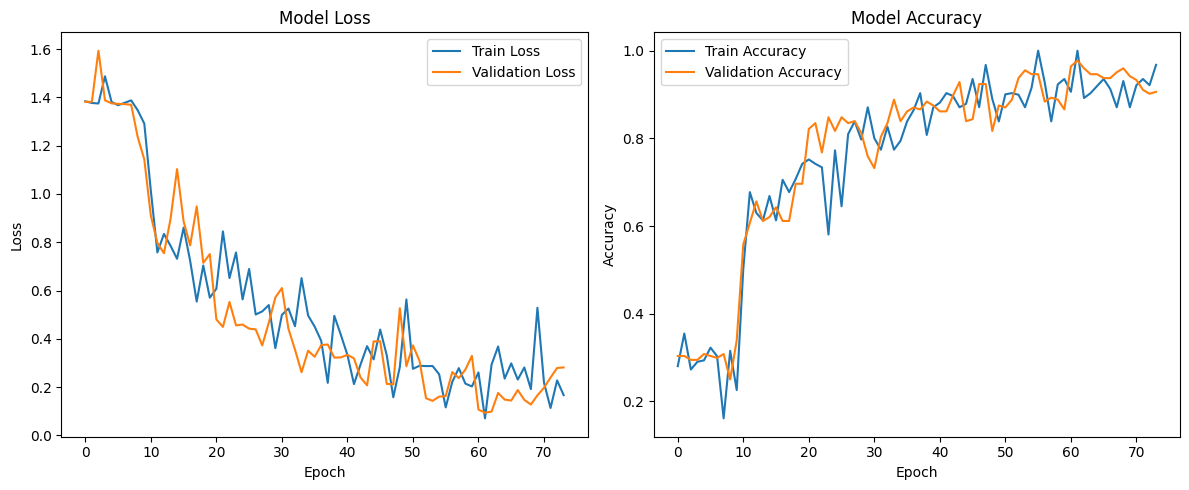

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 최적의 학습 모델 로드

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5', compile=False)

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

best_model_save_path = '/content/drive/MyDrive/my_model/my_vgg16(256).h5'
best_model.save(best_model_save_path)

In [ ]:
best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

## Test_Loss, Test_Accuracy 산출

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.9561 - loss: 0.1139


In [ ]:
print(f'(Best Model) Test_Accuracy: {test_accuracy:.2f}')
print(f'(Best Model) Test_Loss: {test_loss:.2f}')

(Best Model) Test_Accuracy: 0.95
(Best Model) Test_Loss: 0.14


### 최적의 성능인 모델 저장(은닉층의 개수: 256개)

In [ ]:
best_model_save_path = '/content/drive/MyDrive/my_model/my_vgg16(256).h5'

In [ ]:
best_model.save(best_model_save_path)

### 사전 학습되지 않은 모델 로드(VGG16)

In [ ]:
vgg16 = VGG16(weights=None, include_top=False,
                   input_shape=(224, 224, 3))

### 은닉층의 개수: 512로 설정

In [ ]:
# 모델 학습 설정
for layer in vgg16.layers:
    layer.trainable = True

# 클래스 개수 추출
num_classes = len(train_generator.class_indices)

# 층 정보 설정
x = vgg16.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer=HeNormal)(x)

model = Model(inputs=vgg16.input, outputs=predictions)

### 옵티마이저, 손실 함수, 모델 평가 지표 설정

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 조기 종료 및 최적의 모델 저장 옵션 설정

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, verbose=1),
    ModelCheckpoint("best_model.h5",
                    monitor='val_loss',
                    # 최적의 학습 모델 저장
                    save_best_only=True,
                    mode='min',
                    verbose=1)
]

### 모델 학습

In [ ]:
import matplotlib.pyplot as plt

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    # Epoch: 100
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.2885 - loss: 1.3817
Epoch 1: val_loss improved from inf to 1.38380, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 471ms/step - accuracy: 0.2888 - loss: 1.3818 - val_accuracy: 0.2946 - val_loss: 1.3838
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.2581 - loss: 1.3863

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.38380 to 1.38342, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2581 - loss: 1.3863 - val_accuracy: 0.2991 - val_loss: 1.3834
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.2894 - loss: 1.3838
Epoch 3: val_loss improved from 1.38342 to 1.37882, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 433ms/step - accuracy: 0.2897 - loss: 1.3838 - val_accuracy: 0.3036 - val_loss: 1.3788
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3226 - loss: 1.3657
Epoch 4: val_loss improved from 1.37882 to 1.37865, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3226 - loss: 1.3657 - val_accuracy: 0.2991 - val_loss: 1.3786
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.3034 - loss: 1.3765
Epoch 5: val_loss improved from 1.37865 to 1.37690, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.3034 - loss: 1.3763 - val_accuracy: 0.2991 - val_loss: 1.3769
Epoch 6/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1935 - loss: 1.5376
Epoch 6: val_loss improved from 1.37690 to 1.30881, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1935 - loss: 1.5376 - val_accuracy: 0.3080 - val_loss: 1.3088
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.3411 - loss: 1.3059
Epoch 7: val_loss improved from 1.30881 to 1.20693, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 432ms/step - accuracy: 0.3420 - loss: 1.3048 - val_accuracy: 0.4866 - val_loss: 1.2069
Epoch 8/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4839 - loss: 1.4869
Epoch 8: val_loss did not improve from 1.20693
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4839 - loss: 1.4869 - val_accuracy: 0.4286 - val_loss: 1.2602
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4169 - loss: 1.2689
Epoch 9: val_loss improved from 1.20693 to 1.08911, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - accuracy: 0.4174 - loss: 1.2672 - val_accuracy: 0.5134 - val_loss: 1.0891
Epoch 10/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5484 - loss: 1.1012
Epoch 10: val_loss did not improve from 1.08911
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5484 - loss: 1.1012 - val_accuracy: 0.4509 - val_loss: 1.1739
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.4595 - loss: 1.1059
Epoch 11: val_loss improved from 1.08911 to 0.96294, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - accuracy: 0.4597 - loss: 1.1054 - val_accuracy: 0.5312 - val_loss: 0.9629
Epoch 12/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6129 - loss: 0.8504
Epoch 12: val_loss improved from 0.96294 to 0.95738, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6129 - loss: 0.8504 - val_accuracy: 0.5312 - val_loss: 0.9574
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5053 - loss: 1.0362
Epoch 13: val_loss did not improve from 0.95738
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.5053 - loss: 1.0372 - val_accuracy: 0.6071 - val_loss: 0.9686
Epoch 14/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4839 - loss: 1.0239
Epoch 14: val_loss did not improve from 0.95738
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4839 - loss: 1.0239 - val_accuracy: 0.6205 - val_loss: 0.9710
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4750 - loss: 1.0827
Epoch 15: val_loss improved from 0.95738 to 0.83702, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.4756 - loss: 1.0813 - val_accuracy: 0.5982 - val_loss: 0.8370
Epoch 16/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5484 - loss: 0.9885
Epoch 16: val_loss improved from 0.83702 to 0.83422, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5484 - loss: 0.9885 - val_accuracy: 0.5625 - val_loss: 0.8342
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5340 - loss: 0.9706
Epoch 17: val_loss improved from 0.83422 to 0.78393, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.5347 - loss: 0.9702 - val_accuracy: 0.5893 - val_loss: 0.7839
Epoch 18/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6129 - loss: 0.7207
Epoch 18: val_loss improved from 0.78393 to 0.77308, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6129 - loss: 0.7207 - val_accuracy: 0.5982 - val_loss: 0.7731
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5533 - loss: 0.9091
Epoch 19: val_loss improved from 0.77308 to 0.69672, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - accuracy: 0.5536 - loss: 0.9087 - val_accuracy: 0.6830 - val_loss: 0.6967
Epoch 20/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5806 - loss: 0.9617
Epoch 20: val_loss improved from 0.69672 to 0.68522, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5806 - loss: 0.9617 - val_accuracy: 0.6875 - val_loss: 0.6852
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6064 - loss: 0.9035
Epoch 21: val_loss did not improve from 0.68522
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.6068 - loss: 0.9022 - val_accuracy: 0.6920 - val_loss: 0.7248
Epoch 22/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5806 - loss: 0.8853
Epoch 22: val_loss did not improve from 0.68522
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5806 - loss: 0.8853 - val_accuracy: 0.6696 - val_loss: 0.7070
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6746 - loss: 0.7829
Epoch 23: val_loss did not improve from 0.68522
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.6741 - loss: 0.7839 - val_accuracy: 0.7054 - val_loss: 0.7013
Epoch 24/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5161 - loss: 0.9726
Epoch 24: val_loss improved from 0.685

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5161 - loss: 0.9726 - val_accuracy: 0.7411 - val_loss: 0.6349
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6828 - loss: 0.7624
Epoch 25: val_loss improved from 0.63490 to 0.56839, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.6829 - loss: 0.7617 - val_accuracy: 0.7679 - val_loss: 0.5684
Epoch 26/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6774 - loss: 0.7612
Epoch 26: val_loss did not improve from 0.56839
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6774 - loss: 0.7612 - val_accuracy: 0.6920 - val_loss: 0.6510
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7392 - loss: 0.6361
Epoch 27: val_loss improved from 0.56839 to 0.45090, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.7398 - loss: 0.6340 - val_accuracy: 0.8304 - val_loss: 0.4509
Epoch 28/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6452 - loss: 0.6213
Epoch 28: val_loss improved from 0.45090 to 0.36351, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6452 - loss: 0.6213 - val_accuracy: 0.8750 - val_loss: 0.3635
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7441 - loss: 0.5857
Epoch 29: val_loss did not improve from 0.36351
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.7430 - loss: 0.5879 - val_accuracy: 0.7679 - val_loss: 0.5150
Epoch 30/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6774 - loss: 0.6887
Epoch 30: val_loss did not improve from 0.36351
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6774 - loss: 0.6887 - val_accuracy: 0.8304 - val_loss: 0.3984
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7992 - loss: 0.4693
Epoch 31: val_loss did not improve from 0.36351
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.7994 - loss: 0.4696 - val_accuracy: 0.7902 - val_loss: 0.5160
Epoch 32/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8387 - loss: 0.6491
Epoch 32: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8710 - loss: 0.3423 - val_accuracy: 0.8795 - val_loss: 0.3066
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8126 - loss: 0.4765
Epoch 35: val_loss did not improve from 0.30662
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8129 - loss: 0.4761 - val_accuracy: 0.8259 - val_loss: 0.3982
Epoch 36/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8710 - loss: 0.2984
Epoch 36: val_loss did not improve from 0.30662
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8710 - loss: 0.2984 - val_accuracy: 0.8527 - val_loss: 0.3733
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8639 - loss: 0.3881
Epoch 37: val_loss did not improve from 0.30662
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8635 - loss: 0.3889 - val_accuracy: 0.8348 - val_loss: 0.3894
Epoch 38/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9032 - loss: 0.3523
Epoch 38: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9032 - loss: 0.3384 - val_accuracy: 0.8795 - val_loss: 0.2944
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8640 - loss: 0.3454
Epoch 41: val_loss did not improve from 0.29436
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8642 - loss: 0.3450 - val_accuracy: 0.8795 - val_loss: 0.3403
Epoch 42/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8387 - loss: 0.3717
Epoch 42: val_loss improved from 0.29436 to 0.28092, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8387 - loss: 0.3717 - val_accuracy: 0.8929 - val_loss: 0.2809
Epoch 43/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9049 - loss: 0.2653
Epoch 43: val_loss improved from 0.28092 to 0.23569, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.9042 - loss: 0.2670 - val_accuracy: 0.9330 - val_loss: 0.2357
Epoch 44/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9355 - loss: 0.2762
Epoch 44: val_loss did not improve from 0.23569
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9355 - loss: 0.2762 - val_accuracy: 0.9196 - val_loss: 0.2639
Epoch 45/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8998 - loss: 0.3070
Epoch 45: val_loss did not improve from 0.23569
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 411ms/step - accuracy: 0.8995 - loss: 0.3073 - val_accuracy: 0.8929 - val_loss: 0.4015
Epoch 46/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8387 - loss: 0.3038
Epoch 46: val_loss did not improve from 0.23569
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8387 - loss: 0.3038 - val_accuracy: 0.9152 - val_loss: 0.2810
Epoch 47/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8753 - loss: 0.3554
Epoch 47: val_loss improved from 0.235

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.8760 - loss: 0.3536 - val_accuracy: 0.9286 - val_loss: 0.1772
Epoch 48/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8710 - loss: 0.2663
Epoch 48: val_loss improved from 0.17724 to 0.15783, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8710 - loss: 0.2663 - val_accuracy: 0.9509 - val_loss: 0.1578
Epoch 49/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8877 - loss: 0.3084
Epoch 49: val_loss did not improve from 0.15783
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8876 - loss: 0.3091 - val_accuracy: 0.9018 - val_loss: 0.2327
Epoch 50/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8710 - loss: 0.4447
Epoch 50: val_loss did not improve from 0.15783
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8710 - loss: 0.4447 - val_accuracy: 0.9330 - val_loss: 0.1859
Epoch 51/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8920 - loss: 0.2909
Epoch 51: val_loss did not improve from 0.15783
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.8917 - loss: 0.2914 - val_accuracy: 0.8973 - val_loss: 0.2974
Epoch 52/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8387 - loss: 0.3556
Epoch 52: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.8812 - loss: 0.3406 - val_accuracy: 0.9554 - val_loss: 0.1481
Epoch 56/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8710 - loss: 0.2742
Epoch 56: val_loss did not improve from 0.14809
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8710 - loss: 0.2742 - val_accuracy: 0.9241 - val_loss: 0.2018
Epoch 57/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9205 - loss: 0.2165
Epoch 57: val_loss did not improve from 0.14809
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9199 - loss: 0.2178 - val_accuracy: 0.8929 - val_loss: 0.2369
Epoch 58/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9032 - loss: 0.1715
Epoch 58: val_loss did not improve from 0.14809
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9032 - loss: 0.1715 - val_accuracy: 0.9107 - val_loss: 0.2523
Epoch 59/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9040 - loss: 0.2581
Epoch 59: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step - accuracy: 0.9336 - loss: 0.2050 - val_accuracy: 0.9598 - val_loss: 0.1337
Epoch 62/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9677 - loss: 0.1152
Epoch 62: val_loss improved from 0.13370 to 0.11612, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9677 - loss: 0.1152 - val_accuracy: 0.9732 - val_loss: 0.1161
Epoch 63/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9257 - loss: 0.2253
Epoch 63: val_loss did not improve from 0.11612
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9258 - loss: 0.2251 - val_accuracy: 0.9062 - val_loss: 0.2487
Epoch 64/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9677 - loss: 0.1497
Epoch 64: val_loss did not improve from 0.11612
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9677 - loss: 0.1497 - val_accuracy: 0.8571 - val_loss: 0.4214
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9108 - loss: 0.2442
Epoch 65: val_loss did not improve from 0.11612
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.9101 - loss: 0.2465 - val_accuracy: 0.9286 - val_loss: 0.1922
Epoch 66/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9355 - loss: 0.1372
Epoch 66: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9374 - loss: 0.1815 - val_accuracy: 0.9821 - val_loss: 0.0789
Epoch 74/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9677 - loss: 0.0886
Epoch 74: val_loss did not improve from 0.07891
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9677 - loss: 0.0886 - val_accuracy: 0.9688 - val_loss: 0.0858
Epoch 75/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9493 - loss: 0.1552
Epoch 75: val_loss improved from 0.07891 to 0.07589, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9492 - loss: 0.1554 - val_accuracy: 0.9643 - val_loss: 0.0759
Epoch 76/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9032 - loss: 0.1820
Epoch 76: val_loss did not improve from 0.07589
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9032 - loss: 0.1820 - val_accuracy: 0.9688 - val_loss: 0.1015
Epoch 77/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9474 - loss: 0.1360
Epoch 77: val_loss did not improve from 0.07589
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.9474 - loss: 0.1361 - val_accuracy: 0.9241 - val_loss: 0.2360
Epoch 78/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9032 - loss: 0.2162
Epoch 78: val_loss did not improve from 0.07589
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9032 - loss: 0.2162 - val_accuracy: 0.9286 - val_loss: 0.3356
Epoch 79/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9286 - loss: 0.1930
Epoch 79: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step - accuracy: 0.9346 - loss: 0.1761 - val_accuracy: 0.9821 - val_loss: 0.0683
Epoch 86/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9677 - loss: 0.1218
Epoch 86: val_loss did not improve from 0.06828
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9677 - loss: 0.1218 - val_accuracy: 0.9821 - val_loss: 0.0793
Epoch 87/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9500 - loss: 0.1478
Epoch 87: val_loss did not improve from 0.06828
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9497 - loss: 0.1486 - val_accuracy: 0.9777 - val_loss: 0.0698
Epoch 88/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0315
Epoch 88: val_loss did not improve from 0.06828
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0315 - val_accuracy: 0.9821 - val_loss: 0.0762
Epoch 89/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9523 - loss: 0.1196
Epoch 89: val_loss did not improve fro

### 모델 학습 과정 시각화

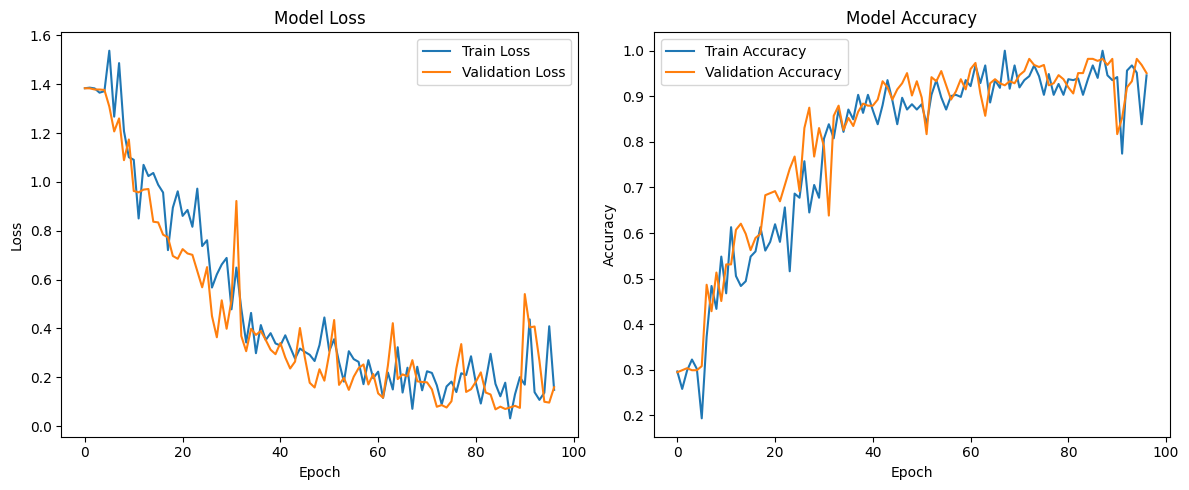

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 최적의 모델 저장(은닉층의 개수: 512)

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5', compile=False)

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

best_model_save_path = '/content/drive/MyDrive/my_model/my_vgg16(512).h5'
best_model.save(best_model_save_path)

In [ ]:
best_model = load_model('/content/drive/MyDrive/my_model/my_vgg16(512).h5')

### 테스트 손실 및 정확도 계산

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.9566 - loss: 0.0983


In [ ]:
print(f'(Best Model) Test_Accuracy: {test_accuracy:.2f}')
print(f'(Best Model) Test_Loss: {test_loss:.2f}')

(Best Model) Test_Accuracy: 0.95
(Best Model) Test_Loss: 0.13


## InceptionV3 로드

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

inception = InceptionV3(weights=None, include_top=False,
                         input_shape=(299, 299, 3))

### 모든 층 학습 가능하도록 속성 변환

In [ ]:
# 모델 학습 설정
for layer in inception.layers:
    layer.trainable = True

In [ ]:
num_classes = len(train_generator.class_indices)

### 층 구조 설계

In [ ]:
x = inception.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

### 옵티마이저, 손실, 모델 평가 지표 설정

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 조기 종료 및 최적 모델 저장 기능 추가

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ModelCheckpoint("best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)
]

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1087 images belonging to 4 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 231 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 238 images belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4057 - loss: 3.8848
Epoch 1: val_loss improved from inf to 397722.50000, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4087 - loss: 3.8506 - val_accuracy: 0.2545 - val_loss: 397722.5000
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5000 - loss: 1.1246
Epoch 2: val_loss did not improve from 397722.50000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.1246 - val_accuracy: 0.2679 - val_loss: 427570.4062
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.5745 - loss: 1.4085
Epoch 3: val_loss improved from 397722.50000 to 1431.50513, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 727ms/step - accuracy: 0.5751 - loss: 1.4326 - val_accuracy: 0.2946 - val_loss: 1431.5051
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6875 - loss: 4.7840
Epoch 4: val_loss improved from 1431.50513 to 943.09509, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6875 - loss: 4.7840 - val_accuracy: 0.2991 - val_loss: 943.0951
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.6475 - loss: 4.8145
Epoch 5: val_loss did not improve from 943.09509
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 662ms/step - accuracy: 0.6475 - loss: 4.7783 - val_accuracy: 0.2545 - val_loss: 1668.7794
Epoch 6/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6562 - loss: 2.5157
Epoch 6: val_loss did not improve from 943.09509
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6562 - loss: 2.5157 - val_accuracy: 0.2991 - val_loss: 1377.0321
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.6369 - loss: 1.6970
Epoch 7: val_loss improved from 943.09509 to 332.74005, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 738ms/step - accuracy: 0.6383 - loss: 1.6895 - val_accuracy: 0.3036 - val_loss: 332.7401
Epoch 8/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7500 - loss: 0.9625
Epoch 8: val_loss improved from 332.74005 to 301.00018, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.7500 - loss: 0.9625 - val_accuracy: 0.3080 - val_loss: 301.0002
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.7627 - loss: 0.8683
Epoch 9: val_loss improved from 301.00018 to 6.70571, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 735ms/step - accuracy: 0.7628 - loss: 0.8641 - val_accuracy: 0.1920 - val_loss: 6.7057
Epoch 10/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9375 - loss: 0.3852
Epoch 10: val_loss improved from 6.70571 to 5.49233, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9375 - loss: 0.3852 - val_accuracy: 0.1652 - val_loss: 5.4923
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8000 - loss: 0.5325
Epoch 11: val_loss improved from 5.49233 to 2.35867, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 713ms/step - accuracy: 0.7999 - loss: 0.5331 - val_accuracy: 0.4062 - val_loss: 2.3587
Epoch 12/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8750 - loss: 0.2934
Epoch 12: val_loss did not improve from 2.35867
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8750 - loss: 0.2934 - val_accuracy: 0.3661 - val_loss: 2.5872
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8556 - loss: 0.4494
Epoch 13: val_loss did not improve from 2.35867
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 659ms/step - accuracy: 0.8554 - loss: 0.4495 - val_accuracy: 0.2991 - val_loss: 6.3127
Epoch 14/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8750 - loss: 0.3474
Epoch 14: val_loss did not improve from 2.35867
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8750 - loss: 0.3474 - val_accuracy: 0.2946 - val_loss: 5.8475
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.8450 - loss: 0.4493
Epoch 15: val_loss improved from 2.358

33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 731ms/step - accuracy: 0.8450 - loss: 0.4494 - val_accuracy: 0.4955 - val_loss: 1.8288
Epoch 16/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8125 - loss: 0.4361
Epoch 16: val_loss improved from 1.82875 to 1.75363, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8125 - loss: 0.4361 - val_accuracy: 0.5134 - val_loss: 1.7536
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8226 - loss: 0.4561
Epoch 17: val_loss did not improve from 1.75363
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - accuracy: 0.8229 - loss: 0.4560 - val_accuracy: 0.3438 - val_loss: 3.5192
Epoch 18/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7812 - loss: 0.4097
Epoch 18: val_loss did not improve from 1.75363
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7812 - loss: 0.4097 - val_accuracy: 0.3393 - val_loss: 3.6473
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8644 - loss: 0.3838
Epoch 19: val_loss improved from 1.75363 to 1.41873, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.8636 - loss: 0.3858 - val_accuracy: 0.5625 - val_loss: 1.4187
Epoch 20/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9062 - loss: 0.2833
Epoch 20: val_loss did not improve from 1.41873
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9062 - loss: 0.2833 - val_accuracy: 0.5759 - val_loss: 1.5251
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8627 - loss: 0.4090
Epoch 21: val_loss improved from 1.41873 to 1.23513, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 736ms/step - accuracy: 0.8629 - loss: 0.4089 - val_accuracy: 0.7321 - val_loss: 1.2351
Epoch 22/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5938 - loss: 0.7314
Epoch 22: val_loss improved from 1.23513 to 1.22962, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5938 - loss: 0.7314 - val_accuracy: 0.7232 - val_loss: 1.2296
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8589 - loss: 0.4548
Epoch 23: val_loss did not improve from 1.22962
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 669ms/step - accuracy: 0.8592 - loss: 0.4534 - val_accuracy: 0.6339 - val_loss: 1.5496
Epoch 24/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8750 - loss: 0.3336
Epoch 24: val_loss did not improve from 1.22962
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8750 - loss: 0.3336 - val_accuracy: 0.5625 - val_loss: 1.7307
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.8624 - loss: 0.3470
Epoch 25: val_loss improved from 1.22962 to 1.14516, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 728ms/step - accuracy: 0.8626 - loss: 0.3475 - val_accuracy: 0.6384 - val_loss: 1.1452
Epoch 26/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8125 - loss: 0.6799
Epoch 26: val_loss improved from 1.14516 to 1.11454, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8125 - loss: 0.6799 - val_accuracy: 0.6562 - val_loss: 1.1145
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8557 - loss: 0.4077
Epoch 27: val_loss improved from 1.11454 to 1.06127, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 716ms/step - accuracy: 0.8558 - loss: 0.4071 - val_accuracy: 0.7411 - val_loss: 1.0613
Epoch 28/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8750 - loss: 0.2925
Epoch 28: val_loss did not improve from 1.06127
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8750 - loss: 0.2925 - val_accuracy: 0.7188 - val_loss: 1.1182
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8790 - loss: 0.3943
Epoch 29: val_loss improved from 1.06127 to 1.04120, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 720ms/step - accuracy: 0.8790 - loss: 0.3931 - val_accuracy: 0.7098 - val_loss: 1.0412
Epoch 30/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8750 - loss: 0.3205
Epoch 30: val_loss did not improve from 1.04120
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8750 - loss: 0.3205 - val_accuracy: 0.7009 - val_loss: 1.1096
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.8843 - loss: 0.3319
Epoch 31: val_loss improved from 1.04120 to 0.84479, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 735ms/step - accuracy: 0.8839 - loss: 0.3327 - val_accuracy: 0.7634 - val_loss: 0.8448
Epoch 32/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9688 - loss: 0.1763
Epoch 32: val_loss did not improve from 0.84479
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9688 - loss: 0.1763 - val_accuracy: 0.7679 - val_loss: 0.8895
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8742 - loss: 0.3223
Epoch 33: val_loss did not improve from 0.84479
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 747ms/step - accuracy: 0.8743 - loss: 0.3225 - val_accuracy: 0.6562 - val_loss: 2.1371
Epoch 34/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7812 - loss: 0.4743
Epoch 34: val_loss did not improve from 0.84479
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7812 - loss: 0.4743 - val_accuracy: 0.6429 - val_loss: 2.3878
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.8790 - loss: 0.3441
Epoch 35: val_loss improved from 0.844

33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 787ms/step - accuracy: 0.8793 - loss: 0.3434 - val_accuracy: 0.9241 - val_loss: 0.1923
Epoch 36/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8438 - loss: 0.2996
Epoch 36: val_loss improved from 0.19228 to 0.17871, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8438 - loss: 0.2996 - val_accuracy: 0.9286 - val_loss: 0.1787
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9055 - loss: 0.2463
Epoch 37: val_loss did not improve from 0.17871
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 727ms/step - accuracy: 0.9053 - loss: 0.2471 - val_accuracy: 0.8304 - val_loss: 0.5037
Epoch 38/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9062 - loss: 0.1795
Epoch 38: val_loss did not improve from 0.17871
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9062 - loss: 0.1795 - val_accuracy: 0.8259 - val_loss: 0.5298
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9184 - loss: 0.2401
Epoch 39: val_loss did not improve from 0.17871
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 712ms/step - accuracy: 0.9182 - loss: 0.2411 - val_accuracy: 0.8929 - val_loss: 0.2485
Epoch 40/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.8125 - loss: 0.4300
Epoch 40: val_loss did not improve fr

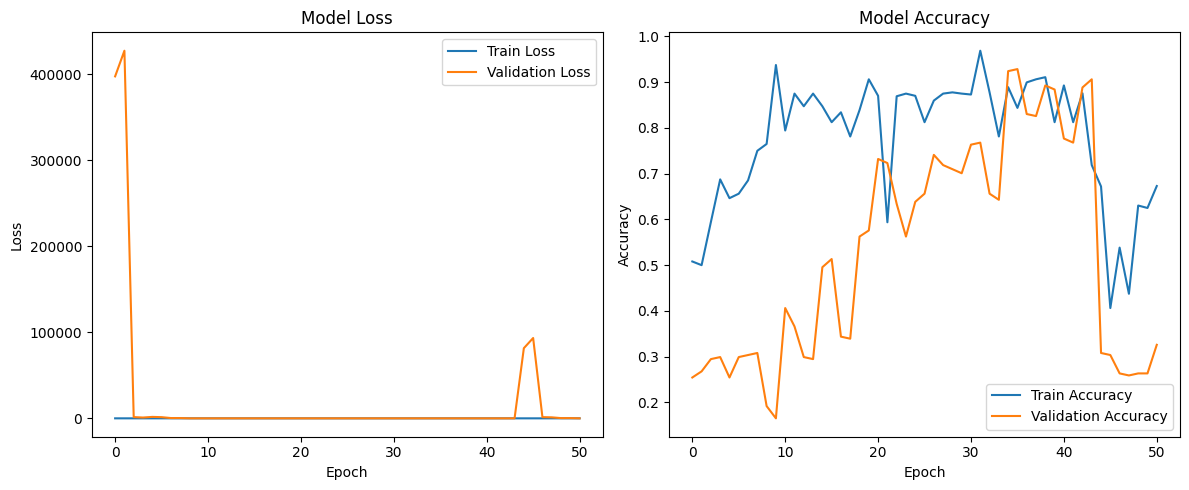

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5', compile=False)

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

best_model_save_path = '/content/drive/MyDrive/my_model/my_inception(256).h5'
best_model.save(best_model_save_path)

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'(Best Model) Test_Accuracy: {test_accuracy:.2f}')
print(f'(Best Model) Test_Loss: {test_loss:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 828ms/step - accuracy: 0.9442 - loss: 0.2466
(Best Model) Test_Accuracy: 0.91
(Best Model) Test_Loss: 0.42


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

inception = InceptionV3(weights=None, include_top=False,
                         input_shape=(299, 299, 3))

In [ ]:
# 모델 학습 설정
for layer in inception.layers:
    layer.trainable = True

In [ ]:
num_classes = len(train_generator.class_indices)

In [ ]:
x = inception.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ModelCheckpoint("best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)
]

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9203 - loss: 0.2626
Epoch 1: val_loss improved from inf to 3.04945, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 765ms/step - accuracy: 0.9202 - loss: 0.2624 - val_accuracy: 0.2723 - val_loss: 3.0494
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7812 - loss: 0.3625
Epoch 2: val_loss did not improve from 3.04945
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7812 - loss: 0.3625 - val_accuracy: 0.2589 - val_loss: 3.1145
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.8981 - loss: 0.3016
Epoch 3: val_loss did not improve from 3.04945
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 666ms/step - accuracy: 0.8984 - loss: 0.3011 - val_accuracy: 0.2009 - val_loss: 6.0600
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9375 - loss: 0.1950
Epoch 4: val_loss did not improve from 3.04945
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.1950 - val_accuracy: 0.2054 - val_loss: 6.4702
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9061 - loss: 0.2619
Epoch 5: val_loss did not improve from 3.0494

33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 752ms/step - accuracy: 0.9198 - loss: 0.2149 - val_accuracy: 0.4286 - val_loss: 3.0111
Epoch 12/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8438 - loss: 0.3671
Epoch 12: val_loss improved from 3.01109 to 2.96348, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.8438 - loss: 0.3671 - val_accuracy: 0.4598 - val_loss: 2.9635
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9365 - loss: 0.1832
Epoch 13: val_loss improved from 2.96348 to 2.15196, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 750ms/step - accuracy: 0.9363 - loss: 0.1842 - val_accuracy: 0.4777 - val_loss: 2.1520
Epoch 14/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7812 - loss: 0.7755
Epoch 14: val_loss did not improve from 2.15196
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7812 - loss: 0.7755 - val_accuracy: 0.4688 - val_loss: 2.1907
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9511 - loss: 0.1867
Epoch 15: val_loss improved from 2.15196 to 1.48041, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 742ms/step - accuracy: 0.9508 - loss: 0.1875 - val_accuracy: 0.6429 - val_loss: 1.4804
Epoch 16/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9375 - loss: 0.1037
Epoch 16: val_loss did not improve from 1.48041
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.1037 - val_accuracy: 0.6429 - val_loss: 1.4841
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9581 - loss: 0.1524
Epoch 17: val_loss improved from 1.48041 to 1.18484, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 753ms/step - accuracy: 0.9577 - loss: 0.1536 - val_accuracy: 0.6875 - val_loss: 1.1848
Epoch 18/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.0540
Epoch 18: val_loss improved from 1.18484 to 1.12695, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 1.0000 - loss: 0.0540 - val_accuracy: 0.6830 - val_loss: 1.1270
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9268 - loss: 0.2321
Epoch 19: val_loss improved from 1.12695 to 0.37844, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 757ms/step - accuracy: 0.9267 - loss: 0.2319 - val_accuracy: 0.8750 - val_loss: 0.3784
Epoch 20/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.0681
Epoch 20: val_loss improved from 0.37844 to 0.37657, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0681 - val_accuracy: 0.8929 - val_loss: 0.3766
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9222 - loss: 0.1862
Epoch 21: val_loss improved from 0.37657 to 0.36070, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 747ms/step - accuracy: 0.9223 - loss: 0.1869 - val_accuracy: 0.8571 - val_loss: 0.3607
Epoch 22/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8438 - loss: 0.3505
Epoch 22: val_loss improved from 0.36070 to 0.32048, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.8438 - loss: 0.3505 - val_accuracy: 0.8616 - val_loss: 0.3205
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9428 - loss: 0.1818
Epoch 23: val_loss improved from 0.32048 to 0.16191, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 760ms/step - accuracy: 0.9427 - loss: 0.1818 - val_accuracy: 0.9286 - val_loss: 0.1619
Epoch 24/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9688 - loss: 0.1791
Epoch 24: val_loss did not improve from 0.16191
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9688 - loss: 0.1791 - val_accuracy: 0.9241 - val_loss: 0.1833
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9512 - loss: 0.1389
Epoch 25: val_loss improved from 0.16191 to 0.14121, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 754ms/step - accuracy: 0.9513 - loss: 0.1386 - val_accuracy: 0.9464 - val_loss: 0.1412
Epoch 26/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9375 - loss: 0.1198
Epoch 26: val_loss improved from 0.14121 to 0.13383, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9375 - loss: 0.1198 - val_accuracy: 0.9509 - val_loss: 0.1338
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9598 - loss: 0.1044
Epoch 27: val_loss did not improve from 0.13383
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - accuracy: 0.9596 - loss: 0.1056 - val_accuracy: 0.9062 - val_loss: 0.3289
Epoch 28/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9688 - loss: 0.0741
Epoch 28: val_loss did not improve from 0.13383
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9688 - loss: 0.0741 - val_accuracy: 0.9018 - val_loss: 0.3045
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9724 - loss: 0.1076
Epoch 29: val_loss did not improve from 0.13383
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 661ms/step - accuracy: 0.9724 - loss: 0.1078 - val_accuracy: 0.9375 - val_loss: 0.1629
Epoch 30/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9062 - loss: 0.1672
Epoch 30: val_loss did not improve fr

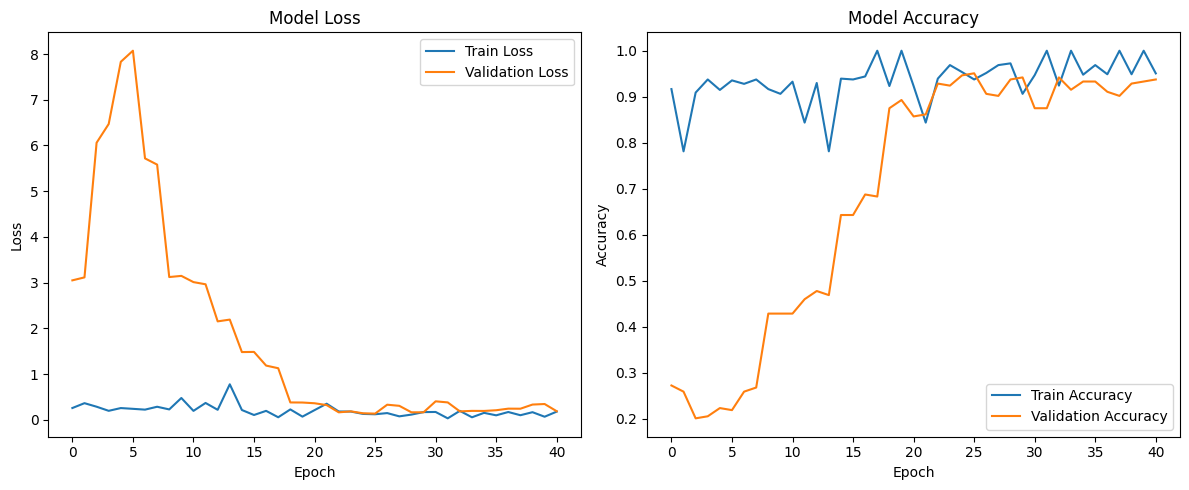

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5', compile=False)

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

best_model_save_path = '/content/drive/MyDrive/my_model/my_inception(512).h5'
best_model.save(best_model_save_path)

In [ ]:
best_model.compile(optimizer='Adam',
                       loss='categorical_crossentropy',
                       metrics=['Accuracy'])

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - Accuracy: 0.9525 - loss: 0.1577


In [ ]:
print(f'(Best Model) Test_Accuracy: {test_accuracy:.2f}')
print(f'(Best Model) Test_Loss: {test_loss:.2f}')

(Best Model) Test_Accuracy: 0.96
(Best Model) Test_Loss: 0.15


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ModelCheckpoint("best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)
]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1087 images belonging to 4 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 231 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 238 images belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3003 - loss: 1.3954
Epoch 1: val_loss improved from inf to 1.26435, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 461ms/step - accuracy: 0.3015 - loss: 1.3946 - val_accuracy: 0.4911 - val_loss: 1.2644
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4375 - loss: 1.2551
Epoch 2: val_loss improved from 1.26435 to 1.25220, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4375 - loss: 1.2551 - val_accuracy: 0.5000 - val_loss: 1.2522
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4963 - loss: 1.2401
Epoch 3: val_loss improved from 1.25220 to 0.96097, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - accuracy: 0.4966 - loss: 1.2393 - val_accuracy: 0.5670 - val_loss: 0.9610
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 1.1020
Epoch 4: val_loss improved from 0.96097 to 0.95696, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5000 - loss: 1.1020 - val_accuracy: 0.5848 - val_loss: 0.9570
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6030 - loss: 1.0127
Epoch 5: val_loss improved from 0.95696 to 0.92636, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.6030 - loss: 1.0120 - val_accuracy: 0.5714 - val_loss: 0.9264
Epoch 6/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5938 - loss: 0.9843
Epoch 6: val_loss improved from 0.92636 to 0.85711, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5938 - loss: 0.9843 - val_accuracy: 0.5938 - val_loss: 0.8571
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6379 - loss: 0.8749
Epoch 7: val_loss improved from 0.85711 to 0.67562, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.6388 - loss: 0.8740 - val_accuracy: 0.7411 - val_loss: 0.6756
Epoch 8/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6875 - loss: 0.7847
Epoch 8: val_loss improved from 0.67562 to 0.61179, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6875 - loss: 0.7847 - val_accuracy: 0.7857 - val_loss: 0.6118
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7013 - loss: 0.7726
Epoch 9: val_loss improved from 0.61179 to 0.60586, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - accuracy: 0.7009 - loss: 0.7729 - val_accuracy: 0.7946 - val_loss: 0.6059
Epoch 10/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7812 - loss: 0.6505
Epoch 10: val_loss did not improve from 0.60586
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7812 - loss: 0.6505 - val_accuracy: 0.7723 - val_loss: 0.6149
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7211 - loss: 0.7022
Epoch 11: val_loss did not improve from 0.60586
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.7210 - loss: 0.7023 - val_accuracy: 0.7679 - val_loss: 0.6369
Epoch 12/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6875 - loss: 0.6391
Epoch 12: val_loss did not improve from 0.60586
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6875 - loss: 0.6391 - val_accuracy: 0.7188 - val_loss: 0.7719
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7403 - loss: 0.6848
Epoch 13: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - accuracy: 0.7352 - loss: 0.6969 - val_accuracy: 0.7812 - val_loss: 0.5068
Epoch 20/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.4950
Epoch 20: val_loss did not improve from 0.50680
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7500 - loss: 0.4950 - val_accuracy: 0.7812 - val_loss: 0.5150
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7822 - loss: 0.5606
Epoch 21: val_loss did not improve from 0.50680
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.7822 - loss: 0.5604 - val_accuracy: 0.7500 - val_loss: 0.6535
Epoch 22/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6562 - loss: 0.7359
Epoch 22: val_loss did not improve from 0.50680
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6562 - loss: 0.7359 - val_accuracy: 0.7277 - val_loss: 0.6709
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7672 - loss: 0.6068
Epoch 23: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - accuracy: 0.8249 - loss: 0.4986 - val_accuracy: 0.7991 - val_loss: 0.4579
Epoch 28/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6875 - loss: 0.7464
Epoch 28: val_loss improved from 0.45795 to 0.43860, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6875 - loss: 0.7464 - val_accuracy: 0.8170 - val_loss: 0.4386
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8337 - loss: 0.4532
Epoch 29: val_loss improved from 0.43860 to 0.32914, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.8330 - loss: 0.4539 - val_accuracy: 0.8884 - val_loss: 0.3291
Epoch 30/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7812 - loss: 0.4582
Epoch 30: val_loss improved from 0.32914 to 0.31765, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7812 - loss: 0.4582 - val_accuracy: 0.8839 - val_loss: 0.3177
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8009 - loss: 0.5071
Epoch 31: val_loss improved from 0.31765 to 0.29943, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.8012 - loss: 0.5067 - val_accuracy: 0.8839 - val_loss: 0.2994
Epoch 32/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.6927
Epoch 32: val_loss did not improve from 0.29943
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7500 - loss: 0.6927 - val_accuracy: 0.8705 - val_loss: 0.3555
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7944 - loss: 0.5104
Epoch 33: val_loss did not improve from 0.29943
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.7952 - loss: 0.5090 - val_accuracy: 0.8973 - val_loss: 0.3422
Epoch 34/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8125 - loss: 0.7420
Epoch 34: val_loss did not improve from 0.29943
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.7420 - val_accuracy: 0.8839 - val_loss: 0.3326
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8379 - loss: 0.4353
Epoch 35: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - accuracy: 0.8561 - loss: 0.3826 - val_accuracy: 0.9062 - val_loss: 0.2632
Epoch 38/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8125 - loss: 0.3560
Epoch 38: val_loss did not improve from 0.26315
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8125 - loss: 0.3560 - val_accuracy: 0.8839 - val_loss: 0.2639
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8077 - loss: 0.4604
Epoch 39: val_loss did not improve from 0.26315
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.8084 - loss: 0.4597 - val_accuracy: 0.8884 - val_loss: 0.3389
Epoch 40/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.2712
Epoch 40: val_loss did not improve from 0.26315
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.2712 - val_accuracy: 0.8750 - val_loss: 0.3598
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8550 - loss: 0.3961
Epoch 41: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 416ms/step - accuracy: 0.8489 - loss: 0.3985 - val_accuracy: 0.9152 - val_loss: 0.2267
Epoch 48/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8750 - loss: 0.3394
Epoch 48: val_loss did not improve from 0.22674
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8750 - loss: 0.3394 - val_accuracy: 0.9107 - val_loss: 0.2387
Epoch 49/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8842 - loss: 0.3332
Epoch 49: val_loss did not improve from 0.22674
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.8841 - loss: 0.3332 - val_accuracy: 0.9152 - val_loss: 0.2305
Epoch 50/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8438 - loss: 0.5016
Epoch 50: val_loss did not improve from 0.22674
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8438 - loss: 0.5016 - val_accuracy: 0.9241 - val_loss: 0.2285
Epoch 51/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9012 - loss: 0.3020
Epoch 51: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9020 - loss: 0.2971 - val_accuracy: 0.9330 - val_loss: 0.2103
Epoch 54/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9062 - loss: 0.3688
Epoch 54: val_loss improved from 0.21028 to 0.17741, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9062 - loss: 0.3688 - val_accuracy: 0.9375 - val_loss: 0.1774
Epoch 55/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9126 - loss: 0.2731
Epoch 55: val_loss did not improve from 0.17741
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9126 - loss: 0.2734 - val_accuracy: 0.9330 - val_loss: 0.1784
Epoch 56/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8438 - loss: 0.3744
Epoch 56: val_loss did not improve from 0.17741
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8438 - loss: 0.3744 - val_accuracy: 0.9286 - val_loss: 0.2104
Epoch 57/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8770 - loss: 0.3279
Epoch 57: val_loss did not improve from 0.17741
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8771 - loss: 0.3275 - val_accuracy: 0.8973 - val_loss: 0.2789
Epoch 58/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8750 - loss: 0.3184
Epoch 58: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - accuracy: 0.9197 - loss: 0.2587 - val_accuracy: 0.9375 - val_loss: 0.1544
Epoch 60/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8438 - loss: 0.3451
Epoch 60: val_loss did not improve from 0.15443
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8438 - loss: 0.3451 - val_accuracy: 0.8929 - val_loss: 0.2665
Epoch 61/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9025 - loss: 0.2950
Epoch 61: val_loss did not improve from 0.15443
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9024 - loss: 0.2949 - val_accuracy: 0.9062 - val_loss: 0.2541
Epoch 62/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9375 - loss: 0.1988
Epoch 62: val_loss did not improve from 0.15443
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9375 - loss: 0.1988 - val_accuracy: 0.9420 - val_loss: 0.1878
Epoch 63/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8980 - loss: 0.2667
Epoch 63: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 416ms/step - accuracy: 0.9170 - loss: 0.2656 - val_accuracy: 0.9598 - val_loss: 0.1172
Epoch 70/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9688 - loss: 0.1331
Epoch 70: val_loss did not improve from 0.11719
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9688 - loss: 0.1331 - val_accuracy: 0.9554 - val_loss: 0.1331
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9248 - loss: 0.2419
Epoch 71: val_loss did not improve from 0.11719
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9246 - loss: 0.2420 - val_accuracy: 0.9420 - val_loss: 0.1418
Epoch 72/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9688 - loss: 0.1208
Epoch 72: val_loss did not improve from 0.11719
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9688 - loss: 0.1208 - val_accuracy: 0.9375 - val_loss: 0.1371
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9394 - loss: 0.1968
Epoch 73: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.9158 - loss: 0.2807 - val_accuracy: 0.9464 - val_loss: 0.1149
Epoch 80/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1312
Epoch 80: val_loss improved from 0.11493 to 0.10160, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.1312 - val_accuracy: 0.9598 - val_loss: 0.1016
Epoch 81/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9391 - loss: 0.1713
Epoch 81: val_loss did not improve from 0.10160
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.9389 - loss: 0.1718 - val_accuracy: 0.8973 - val_loss: 0.2299
Epoch 82/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8125 - loss: 0.4305
Epoch 82: val_loss did not improve from 0.10160
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8125 - loss: 0.4305 - val_accuracy: 0.8973 - val_loss: 0.2796
Epoch 83/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9105 - loss: 0.2724
Epoch 83: val_loss did not improve from 0.10160
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.9102 - loss: 0.2726 - val_accuracy: 0.9241 - val_loss: 0.1972
Epoch 84/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8750 - loss: 0.2618
Epoch 84: val_loss did not improve fro

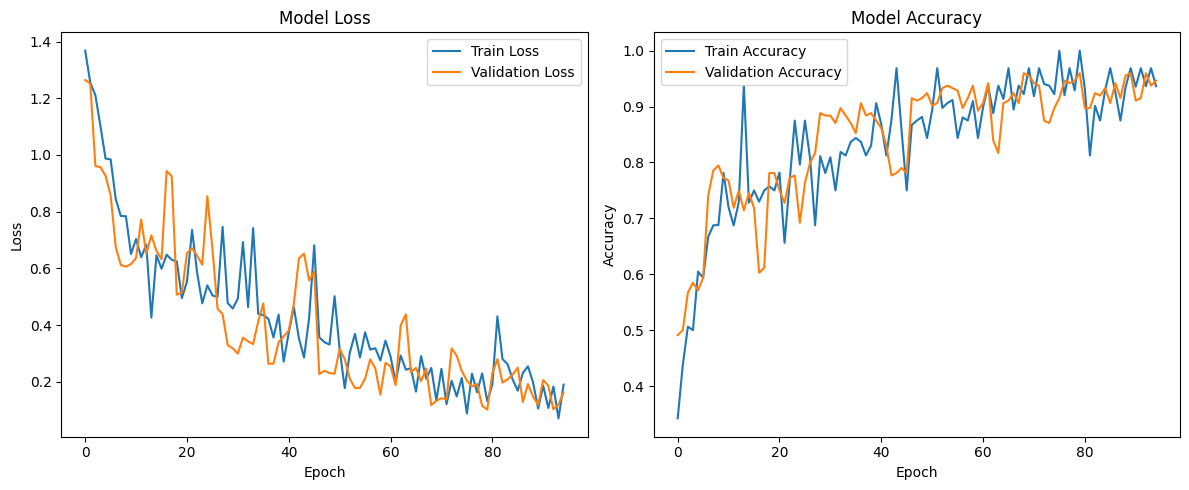

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5', compile=False)

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

best_model_save_path = '/content/drive/MyDrive/my_model/my_cnn(256).h5'
best_model.save(best_model_save_path)

In [ ]:
best_model.compile(optimizer='Adam',
                       loss='categorical_crossentropy',
                       metrics=['Accuracy'])

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f'(Best Model) Test_Accuracy: {test_accuracy:.2f}')
print(f'(Best Model) Test_Loss: {test_loss:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - Accuracy: 0.9740 - loss: 0.0610
(Best Model) Test_Accuracy: 0.97
(Best Model) Test_Loss: 0.09


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ModelCheckpoint("best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)
]

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.2731 - loss: 1.4263
Epoch 1: val_loss improved from inf to 1.19434, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.2750 - loss: 1.4244 - val_accuracy: 0.4866 - val_loss: 1.1943
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4375 - loss: 1.1762
Epoch 2: val_loss did not improve from 1.19434
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4375 - loss: 1.1762 - val_accuracy: 0.5000 - val_loss: 1.1970
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.4613 - loss: 1.2237
Epoch 3: val_loss improved from 1.19434 to 1.01702, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.4617 - loss: 1.2230 - val_accuracy: 0.5804 - val_loss: 1.0170
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5625 - loss: 1.1112
Epoch 4: val_loss did not improve from 1.01702
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5625 - loss: 1.1112 - val_accuracy: 0.5982 - val_loss: 1.0234
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5387 - loss: 1.0517
Epoch 5: val_loss improved from 1.01702 to 0.72128, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.5401 - loss: 1.0502 - val_accuracy: 0.7098 - val_loss: 0.7213
Epoch 6/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6250 - loss: 0.9546
Epoch 6: val_loss did not improve from 0.72128
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6250 - loss: 0.9546 - val_accuracy: 0.7411 - val_loss: 0.7358
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6548 - loss: 0.8844
Epoch 7: val_loss improved from 0.72128 to 0.58566, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.6553 - loss: 0.8832 - val_accuracy: 0.7634 - val_loss: 0.5857
Epoch 8/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5625 - loss: 0.9169
Epoch 8: val_loss improved from 0.58566 to 0.57750, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5625 - loss: 0.9169 - val_accuracy: 0.7768 - val_loss: 0.5775
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6667 - loss: 0.8101
Epoch 9: val_loss did not improve from 0.57750
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.6676 - loss: 0.8081 - val_accuracy: 0.7009 - val_loss: 0.6450
Epoch 10/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7188 - loss: 0.6757
Epoch 10: val_loss did not improve from 0.57750
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7188 - loss: 0.6757 - val_accuracy: 0.7009 - val_loss: 0.6508
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7226 - loss: 0.6959
Epoch 11: val_loss improved from 0.57750 to 0.50098, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.7226 - loss: 0.6952 - val_accuracy: 0.8036 - val_loss: 0.5010
Epoch 12/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7812 - loss: 0.5422
Epoch 12: val_loss did not improve from 0.50098
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7812 - loss: 0.5422 - val_accuracy: 0.7768 - val_loss: 0.5271
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7554 - loss: 0.6197
Epoch 13: val_loss did not improve from 0.50098
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.7556 - loss: 0.6193 - val_accuracy: 0.8214 - val_loss: 0.5395
Epoch 14/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6250 - loss: 0.7791
Epoch 14: val_loss did not improve from 0.50098
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6250 - loss: 0.7791 - val_accuracy: 0.8214 - val_loss: 0.5321
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7654 - loss: 0.6001
Epoch 15: val_loss improved from 0.500

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.7654 - loss: 0.6005 - val_accuracy: 0.8348 - val_loss: 0.4840
Epoch 16/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6875 - loss: 0.7378
Epoch 16: val_loss did not improve from 0.48399
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6875 - loss: 0.7378 - val_accuracy: 0.8214 - val_loss: 0.5154
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8007 - loss: 0.5387
Epoch 17: val_loss did not improve from 0.48399
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8006 - loss: 0.5390 - val_accuracy: 0.7455 - val_loss: 0.7040
Epoch 18/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7812 - loss: 0.6254
Epoch 18: val_loss did not improve from 0.48399
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7812 - loss: 0.6254 - val_accuracy: 0.7455 - val_loss: 0.6753
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8086 - loss: 0.5185
Epoch 19: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6875 - loss: 0.5316 - val_accuracy: 0.8571 - val_loss: 0.4585
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7820 - loss: 0.5324
Epoch 21: val_loss improved from 0.45855 to 0.42761, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - accuracy: 0.7821 - loss: 0.5322 - val_accuracy: 0.8527 - val_loss: 0.4276
Epoch 22/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7188 - loss: 0.6297
Epoch 22: val_loss improved from 0.42761 to 0.35684, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7188 - loss: 0.6297 - val_accuracy: 0.8661 - val_loss: 0.3568
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7868 - loss: 0.5421
Epoch 23: val_loss did not improve from 0.35684
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.7870 - loss: 0.5415 - val_accuracy: 0.8661 - val_loss: 0.3743
Epoch 24/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.4584
Epoch 24: val_loss did not improve from 0.35684
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7500 - loss: 0.4584 - val_accuracy: 0.8705 - val_loss: 0.4240
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8291 - loss: 0.4729
Epoch 25: val_loss did not improve from 0.35684
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.8291 - loss: 0.4726 - val_accuracy: 0.8214 - val_loss: 0.4944
Epoch 26/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.2669
Epoch 26: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.8387 - loss: 0.4673 - val_accuracy: 0.8705 - val_loss: 0.3237
Epoch 30/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.3179
Epoch 30: val_loss improved from 0.32370 to 0.31314, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9062 - loss: 0.3179 - val_accuracy: 0.8795 - val_loss: 0.3131
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8690 - loss: 0.3832
Epoch 31: val_loss did not improve from 0.31314
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.8684 - loss: 0.3838 - val_accuracy: 0.8438 - val_loss: 0.3553
Epoch 32/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9062 - loss: 0.4546
Epoch 32: val_loss did not improve from 0.31314
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.4546 - val_accuracy: 0.8571 - val_loss: 0.4048
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8724 - loss: 0.3576
Epoch 33: val_loss improved from 0.31314 to 0.26337, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.8727 - loss: 0.3570 - val_accuracy: 0.9241 - val_loss: 0.2634
Epoch 34/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8438 - loss: 0.3755
Epoch 34: val_loss did not improve from 0.26337
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8438 - loss: 0.3755 - val_accuracy: 0.8884 - val_loss: 0.2971
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8612 - loss: 0.4198
Epoch 35: val_loss did not improve from 0.26337
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.8615 - loss: 0.4181 - val_accuracy: 0.8973 - val_loss: 0.2903
Epoch 36/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9375 - loss: 0.2211
Epoch 36: val_loss did not improve from 0.26337
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9375 - loss: 0.2211 - val_accuracy: 0.8705 - val_loss: 0.3500
Epoch 37/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8681 - loss: 0.3375
Epoch 37: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.8616 - loss: 0.3672 - val_accuracy: 0.9152 - val_loss: 0.1964
Epoch 48/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8125 - loss: 0.4612
Epoch 48: val_loss did not improve from 0.19643
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8125 - loss: 0.4612 - val_accuracy: 0.9196 - val_loss: 0.2064
Epoch 49/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8417 - loss: 0.3818
Epoch 49: val_loss did not improve from 0.19643
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.8425 - loss: 0.3805 - val_accuracy: 0.9330 - val_loss: 0.2065
Epoch 50/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9062 - loss: 0.2689
Epoch 50: val_loss did not improve from 0.19643
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.2689 - val_accuracy: 0.9330 - val_loss: 0.2331
Epoch 51/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9105 - loss: 0.2722
Epoch 51: val_loss improved from 0.196

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.9107 - loss: 0.2719 - val_accuracy: 0.9330 - val_loss: 0.1805
Epoch 52/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9375 - loss: 0.4105
Epoch 52: val_loss did not improve from 0.18052
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9375 - loss: 0.4105 - val_accuracy: 0.9330 - val_loss: 0.2007
Epoch 53/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9160 - loss: 0.2449
Epoch 53: val_loss did not improve from 0.18052
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.9159 - loss: 0.2455 - val_accuracy: 0.8259 - val_loss: 0.5304
Epoch 54/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8750 - loss: 0.3424
Epoch 54: val_loss did not improve from 0.18052
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.3424 - val_accuracy: 0.8036 - val_loss: 0.5651
Epoch 55/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9160 - loss: 0.2495
Epoch 55: val_loss did not improve fro

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5', compile=False)

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# best_model_save_path = '/content/drive/MyDrive/my_model/my_cnn(512).h5'
# best_model.save(best_model_save_path)

In [ ]:
best_model.compile(optimizer='Adam',
                       loss='categorical_crossentropy',
                       metrics=['Accuracy'])

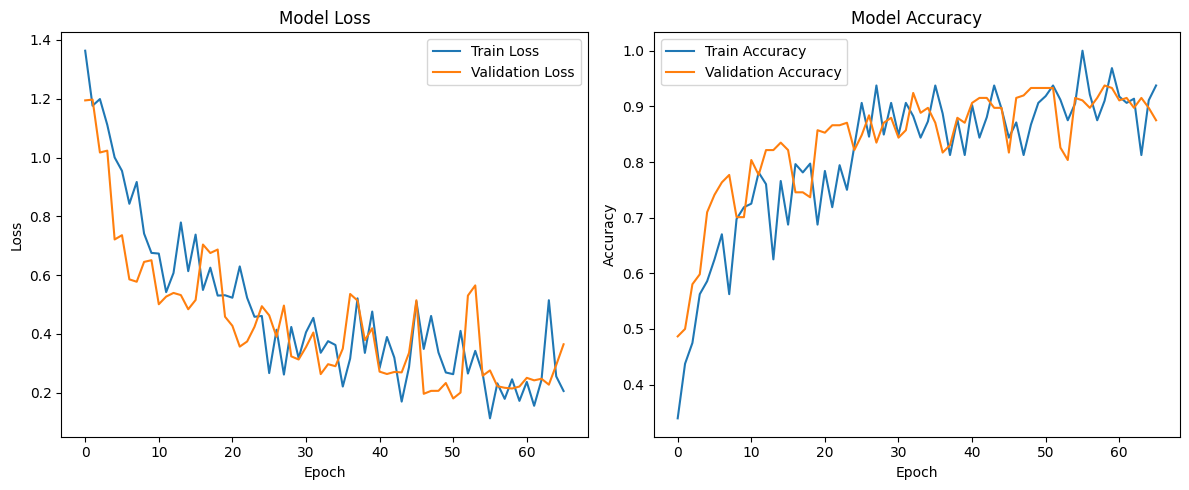

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f'(Best Model) Test_Accuracy: {test_accuracy:.2f}')
print(f'(Best Model) Test_Loss: {test_loss:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - Accuracy: 0.9581 - loss: 0.1111
(Best Model) Test_Accuracy: 0.96
(Best Model) Test_Loss: 0.13


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

num_classes = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ModelCheckpoint("best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1)
]

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.3534 - loss: 1.4040
Epoch 1: val_loss improved from inf to 0.96649, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.3556 - loss: 1.4004 - val_accuracy: 0.5312 - val_loss: 0.9665
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5938 - loss: 1.0081
Epoch 2: val_loss improved from 0.96649 to 0.89953, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5938 - loss: 1.0081 - val_accuracy: 0.5491 - val_loss: 0.8995
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6200 - loss: 0.9694
Epoch 3: val_loss improved from 0.89953 to 0.73154, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.6205 - loss: 0.9675 - val_accuracy: 0.6741 - val_loss: 0.7315
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5938 - loss: 0.9717
Epoch 4: val_loss improved from 0.73154 to 0.70974, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5938 - loss: 0.9717 - val_accuracy: 0.6875 - val_loss: 0.7097
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6966 - loss: 0.7556
Epoch 5: val_loss improved from 0.70974 to 0.53427, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.6966 - loss: 0.7554 - val_accuracy: 0.7723 - val_loss: 0.5343
Epoch 6/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7812 - loss: 0.5456
Epoch 6: val_loss did not improve from 0.53427
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7812 - loss: 0.5456 - val_accuracy: 0.7634 - val_loss: 0.5664
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6935 - loss: 0.7051
Epoch 7: val_loss did not improve from 0.53427
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.6940 - loss: 0.7055 - val_accuracy: 0.6786 - val_loss: 0.7188
Epoch 8/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8438 - loss: 0.4689
Epoch 8: val_loss did not improve from 0.53427
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8438 - loss: 0.4689 - val_accuracy: 0.7009 - val_loss: 0.7088
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7130 - loss: 0.7093
Epoch 9: val_loss did not improve from 0.5342

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.7581 - loss: 0.5897 - val_accuracy: 0.8348 - val_loss: 0.5083
Epoch 12/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8750 - loss: 0.4394
Epoch 12: val_loss improved from 0.50828 to 0.48822, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8750 - loss: 0.4394 - val_accuracy: 0.8259 - val_loss: 0.4882
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7545 - loss: 0.6156
Epoch 13: val_loss did not improve from 0.48822
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.7550 - loss: 0.6149 - val_accuracy: 0.7946 - val_loss: 0.6490
Epoch 14/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8438 - loss: 0.4559
Epoch 14: val_loss did not improve from 0.48822
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8438 - loss: 0.4559 - val_accuracy: 0.7455 - val_loss: 0.7620
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7905 - loss: 0.5689
Epoch 15: val_loss did not improve from 0.48822
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.7901 - loss: 0.5689 - val_accuracy: 0.7232 - val_loss: 0.7412
Epoch 16/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7188 - loss: 0.5661
Epoch 16: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.7713 - loss: 0.5379 - val_accuracy: 0.8750 - val_loss: 0.3631
Epoch 18/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7812 - loss: 0.4948
Epoch 18: val_loss did not improve from 0.36308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7812 - loss: 0.4948 - val_accuracy: 0.8795 - val_loss: 0.4022
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8523 - loss: 0.4313
Epoch 19: val_loss did not improve from 0.36308
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.8517 - loss: 0.4327 - val_accuracy: 0.8750 - val_loss: 0.4068
Epoch 20/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7812 - loss: 0.4387
Epoch 20: val_loss did not improve from 0.36308
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7812 - loss: 0.4387 - val_accuracy: 0.8080 - val_loss: 0.5637
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8451 - loss: 0.4727
Epoch 21: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.8583 - loss: 0.3988 - val_accuracy: 0.8884 - val_loss: 0.3571
Epoch 24/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9688 - loss: 0.2560
Epoch 24: val_loss did not improve from 0.35711
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9688 - loss: 0.2560 - val_accuracy: 0.8661 - val_loss: 0.3969
Epoch 25/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8644 - loss: 0.3931
Epoch 25: val_loss did not improve from 0.35711
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.8643 - loss: 0.3931 - val_accuracy: 0.8661 - val_loss: 0.4065
Epoch 26/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8750 - loss: 0.4488
Epoch 26: val_loss did not improve from 0.35711
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.4488 - val_accuracy: 0.8393 - val_loss: 0.4275
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8197 - loss: 0.4264
Epoch 27: val_loss improved from 0.357

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.8203 - loss: 0.4256 - val_accuracy: 0.8795 - val_loss: 0.3226
Epoch 28/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8125 - loss: 0.3697
Epoch 28: val_loss improved from 0.32259 to 0.32131, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8125 - loss: 0.3697 - val_accuracy: 0.9018 - val_loss: 0.3213
Epoch 29/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8769 - loss: 0.3993
Epoch 29: val_loss did not improve from 0.32131
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.8764 - loss: 0.3995 - val_accuracy: 0.8482 - val_loss: 0.4495
Epoch 30/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8125 - loss: 0.3736
Epoch 30: val_loss did not improve from 0.32131
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.3736 - val_accuracy: 0.8214 - val_loss: 0.5206
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8886 - loss: 0.3409
Epoch 31: val_loss improved from 0.32131 to 0.26762, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.8883 - loss: 0.3416 - val_accuracy: 0.9196 - val_loss: 0.2676
Epoch 32/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.2374
Epoch 32: val_loss did not improve from 0.26762
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.2374 - val_accuracy: 0.8616 - val_loss: 0.3662
Epoch 33/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8835 - loss: 0.3224
Epoch 33: val_loss did not improve from 0.26762
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.8835 - loss: 0.3222 - val_accuracy: 0.9107 - val_loss: 0.2782
Epoch 34/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.3558
Epoch 34: val_loss did not improve from 0.26762
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.3558 - val_accuracy: 0.9062 - val_loss: 0.2803
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9172 - loss: 0.2571
Epoch 35: val_loss did not improve fro

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 447ms/step - accuracy: 0.8833 - loss: 0.3198 - val_accuracy: 0.9241 - val_loss: 0.2608
Epoch 38/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8750 - loss: 0.3018
Epoch 38: val_loss did not improve from 0.26076
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.3018 - val_accuracy: 0.9152 - val_loss: 0.2716
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8839 - loss: 0.3464
Epoch 39: val_loss improved from 0.26076 to 0.24450, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.8845 - loss: 0.3451 - val_accuracy: 0.9330 - val_loss: 0.2445
Epoch 40/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9375 - loss: 0.2596
Epoch 40: val_loss did not improve from 0.24450
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9375 - loss: 0.2596 - val_accuracy: 0.9241 - val_loss: 0.2517
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9062 - loss: 0.2848
Epoch 41: val_loss did not improve from 0.24450
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.9065 - loss: 0.2841 - val_accuracy: 0.9107 - val_loss: 0.2659
Epoch 42/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8750 - loss: 0.2862
Epoch 42: val_loss did not improve from 0.24450
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.2862 - val_accuracy: 0.8973 - val_loss: 0.2871
Epoch 43/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9001 - loss: 0.2688
Epoch 43: val_loss improved from 0.244

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 445ms/step - accuracy: 0.9001 - loss: 0.2694 - val_accuracy: 0.9464 - val_loss: 0.1431
Epoch 44/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7812 - loss: 0.4688
Epoch 44: val_loss did not improve from 0.14310
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7812 - loss: 0.4688 - val_accuracy: 0.9464 - val_loss: 0.1591
Epoch 45/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8988 - loss: 0.2941
Epoch 45: val_loss did not improve from 0.14310
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.8988 - loss: 0.2939 - val_accuracy: 0.9018 - val_loss: 0.2892
Epoch 46/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9062 - loss: 0.1715
Epoch 46: val_loss did not improve from 0.14310
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.1715 - val_accuracy: 0.9018 - val_loss: 0.2927
Epoch 47/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9111 - loss: 0.2540
Epoch 47: val_loss did not improve fro

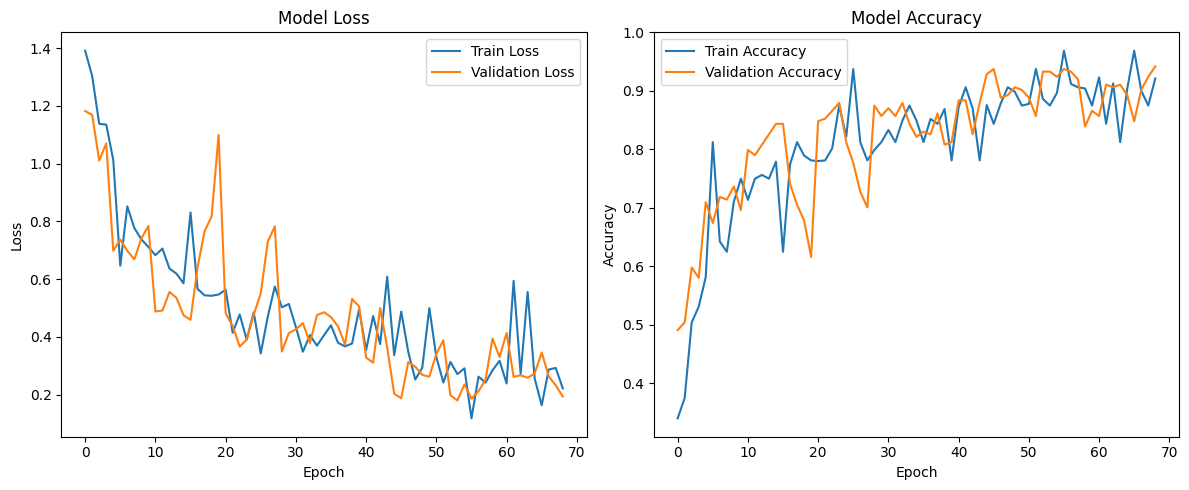

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5', compile=False)

best_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

best_model_save_path = '/content/drive/MyDrive/my_model/my_cnn(512_Leaky_ReLU_Ver).h5'
best_model.save(best_model_save_path)

In [ ]:
best_model.compile(optimizer='Adam',
                       loss='categorical_crossentropy',
                       metrics=['Accuracy'])

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f'(Best Model) Test_Accuracy: {test_accuracy:.2f}')
print(f'(Best Model) Test_Loss: {test_loss:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - Accuracy: 0.9668 - loss: 0.0932
(Best Model) Test_Accuracy: 0.96
(Best Model) Test_Loss: 0.10
